In [1]:
import os
import fsps
import zeus
import numpy as np 
import scipy.optimize as op

In [2]:
from provabgs import infer as Infer

In [3]:
# --- plotting --- 
import corner as DFM
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
tlb = np.load('/Users/chahah/data/provabgs/prior_correct/t.lookback.npy')
nlb = len(tlb)
tage = tlb[-1]

# delta t bin widths
dt = np.zeros(nlb)
dt[1:-1] = 0.5 * (np.diff(tlb)[1:] + np.diff(tlb)[:-1]) 
dt[0]   = 0.5 * (tlb[1] - tlb[0]) 
dt[-1]  = 0.5 * (tlb[-1] - tlb[-2]) 

In [5]:
lbls = ['constant', 'falling', 'rising', 'burst', 'quench']


wave = np.load('/Users/chahah/data/provabgs/prior_correct/wave.fsps.npy')

sfhs, seds = [], []
for lbl in lbls: 
    sfhs.append(np.load('/Users/chahah/data/provabgs/prior_correct/sfh.%s.npy' % lbl))
    seds.append(np.load('/Users/chahah/data/provabgs/prior_correct/sed.%s.npy' % lbl))

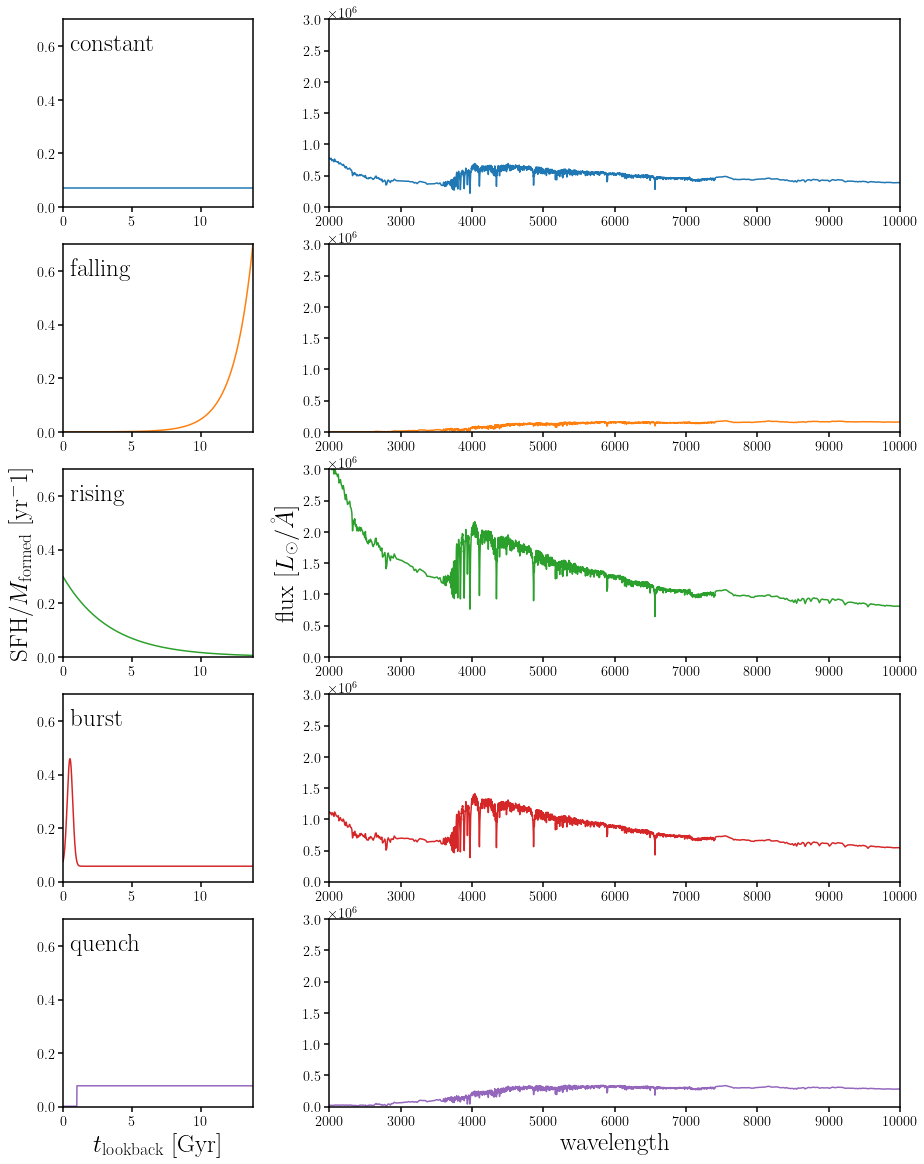

In [6]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, lbl in zip(range(5), sfhs, seds, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)

# run SED fitting on the mock data using a simple non-parametric SFH

In [7]:
ssp = fsps.StellarPopulation(
    zcontinuous=1, # interpolate metallicities
    sfh=0,         # tau model
    dust_type=2,   # calzetti(2000)
    imf_type=1)    # chabrier IMF 

SED model where the spectra is composed of 7 separate SSP, each at a different age

In [8]:
tage_bins = np.array([0., 0.03, 0.1, 0.33, 1.1, 3.6, 11.7, tage+1e-5])
dtage = np.array([0.03, 0.07, 0.23, 0.77, 2.5, 8.1, tage-11.7])

# resample SFH 
tlb_sfh = np.array(np.sort(np.concatenate([np.linspace(0, tage, 100), tage_bins[1:-1]])))

tlb_mid_sfh = 0.5 * (tlb_sfh[:-1] + tlb_sfh[1:])
nlb_mid_sfh = len(tlb_mid_sfh)
dt_sfh = np.diff(tlb_sfh) # width of sfh time bins
ibin_sfh = np.array([np.digitize(t, tage_bins)-1 for t in tlb_mid_sfh])

def SED(theta): 
    ''' 7 parameter SED model where each parameter specifies the fraction mass formed
    in time bin
    '''
    # sfh parameters
    ssp.params['logzsol']  = 0 # log(z/zsun) 
    ssp.params['dust2']    = 0.3  # dust2 parameter in fsps 

    assert np.isclose(np.sum(theta), 1)

    mtot = 0.
    for i, tage, ibin in zip(range(nlb_mid_sfh), tlb_mid_sfh, ibin_sfh):
        m = dt_sfh[i] * theta[ibin] / dtage[ibin] # mass formed in this bin 
        if m == 0 and i != 0: continue 
        
        w, _l_ssp = ssp.get_spectrum(
                tage=np.clip(tage, 1e-8, None), 
                peraa=True) # in units of Lsun/AA    
        
        if i == 0: l_ssp = np.zeros(len(w))
        l_ssp += m * _l_ssp
        mtot += m
    assert np.isclose(mtot, 1.), mtot

    # mass normalization
    l_ssp *= (10**10)
    return w, l_ssp 

## define prior
Dirchlet prior on the 7 SFH parameters so that they add up to 1

In [9]:
dirch = Infer.FlatDirichletPrior(7)

In [10]:
def lnPrior(theta_unt):
    ''' uniform priors on tau, sf start, fburst, tburst
    '''
    return dirch.lnPrior(theta_unt)

## define likelihood and posterior
simple chi-squared likelihood

In [11]:
wlim = (wave > 2e3) & (wave < 1e4) # wavelength limit for convenience

def lnLike(theta_unt, flux_obs, ivar_obs): 
    ''' simple Gaussian likelihood
    '''
    # get tau model SED
    w, flux_model = SED(dirch.transform(theta_unt))
    
    # calculate chi2
    chi2 = np.sum((flux_obs - flux_model[wlim])**2 * ivar_obs)
    
    return -0.5 * chi2

def lnPost(theta_unt, flux_obs, ivar_obs): 
    ''' log posterior
    '''
    lp = lnPrior(theta_unt)
    if not np.isfinite(lp): 
        return -np.inf
    
    lnlike = lnLike(theta_unt, flux_obs, ivar_obs)

    return lp + lnlike

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.11053673 0.19913494 0.64101908 0.0216386  0.0249414  0.00121156
 0.00151768]


/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.0497014  0.22101693 0.22768857 0.40900078 0.07006034 0.00074368
 0.0217883 ]


/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.50212524e-01 9.48255665e-03 2.22570008e-01 4.42200133e-01
 1.68985301e-01 6.24937488e-05 6.48698367e-03]


/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.067222   0.09753492 0.49288841 0.02519045 0.29189539 0.01673355
 0.00853527]


/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.12691609 0.20095534 0.5198915  0.00296397 0.04001789 0.06256134
 0.04669388]


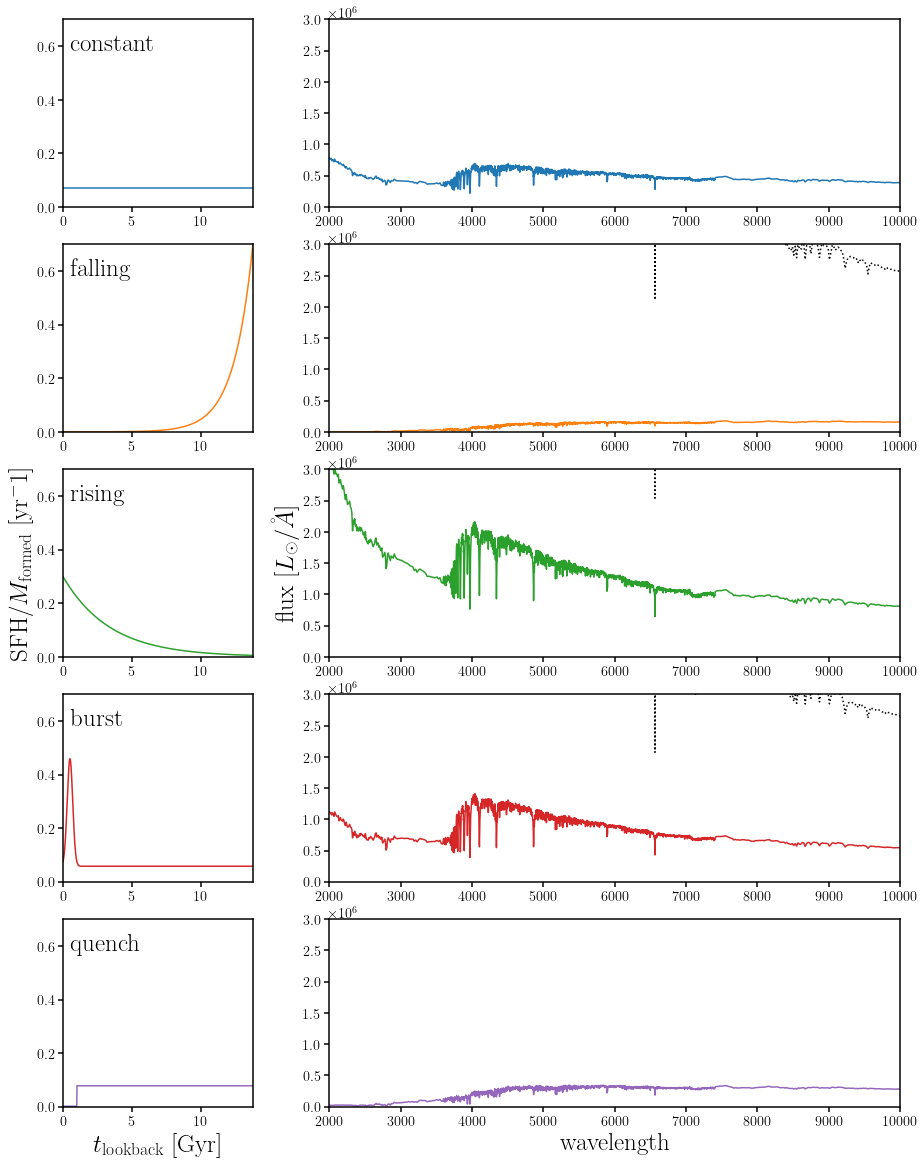

In [13]:
nwalkers, ndim = 20, 6

fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 


# get starting positions for walkers
starts = [] 
for i, sed in enumerate(seds): 
    # initialize walkers
    _lnpost = lambda *args: -2. * lnPost(*args)
    
    min_result = op.minimize(
        _lnpost, 
        np.random.uniform(size=6), 
        args=(sed[wlim], np.ones(np.sum(wlim))))
    
    tt0 = min_result['x'] 
    logp0 = -0.5*min_result['fun']
    start = [tt0 + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)]    
    print(dirch.transform(tt0))
    starts.append(start)
    
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfhs[i], c='C%i' % i, label=lbl)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbls[i], ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbls[i])
    w, flux_model = SED(dirch.transform(tt0))
    
    sub.plot(w, flux_model, c='k', ls=':')
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)
    

In [14]:
samplers = []
for i, sed in enumerate(seds): 
    sampler = zeus.EnsembleSampler(
        nwalkers, 
        ndim, 
        lnPost, 
        args=(sed[wlim], np.ones(np.sum(wlim))))
    sampler.run_mcmc(starts[i], 10000, progress=True)
    samplers.append(sampler)

Initialising ensemble of 20 walkers...
Sampling progress :   2%|▏         | 169/10000 [12:00:55<169:20:31, 62.01s/it]    

KeyboardInterrupt: 

In [ ]:
# save the chains
for sampler, lbl in zip(samplers, lbls): 
    chain = sampler.get_chain()
    np.save('/Users/chahah/data/provabgs/prior_correct/mcmc.%s.nocorr.npy' % lbl, chain)

In [13]:
nwalkers, ndim = 20, 4
chains = [] 
# save the chains
for lbl in lbls:
    chains.append(np.load('/Users/chahah/data/provabgs/prior_correct/mcmc.%s.nocorr.npy' % lbl))

In [14]:
def SFH(theta): 
    ''' tau star formation history for given parameter values.
    '''
    from scipy.special import gammainc
    tau_sfh, sf_start, fburst, tburst = theta
    
    # tau or delayed-tau 
    power = 1 

    t = np.linspace(sf_start, tage, 1000)
    tlookback = t - sf_start
    dt = np.diff(t)[0]
    dts = np.repeat(dt, 1000)
    dts[0] *= 0.5
    dts[-1] *= 0.5

    tmax = (tage - sf_start) / tau_sfh
    normalized_t = (t - sf_start)/tau_sfh

    # constant contribution 
    sfh = np.zeros(1000)

    # burst contribution 
    tb = (tburst - sf_start) / tau_sfh
    if tb > 0 and fburst > 0: 
        iburst = np.floor(tb / dt * tau_sfh).astype(int)
        sfh[iburst] += fburst / dts[iburst]

    # tau contribution 
    ftau = (1.  - fburst) 
    sfh_tau = (normalized_t **(power - 1) * np.exp(-normalized_t))
    sfh += sfh_tau * (ftau / tau_sfh / np.trapz(sfh_tau, normalized_t))
    return tlookback, sfh 

[ 0.50896263 12.79629076  0.93422357  8.52434174]
[ 0.34930537 12.79628619  0.99993996  1.63945058]
[ 0.74635536 12.79629076  0.79068353 11.04085799]
[ 0.21333632 12.79629076  0.67205107  6.27226999]
[ 0.30412402 11.26501561  0.82850403  6.28196804]


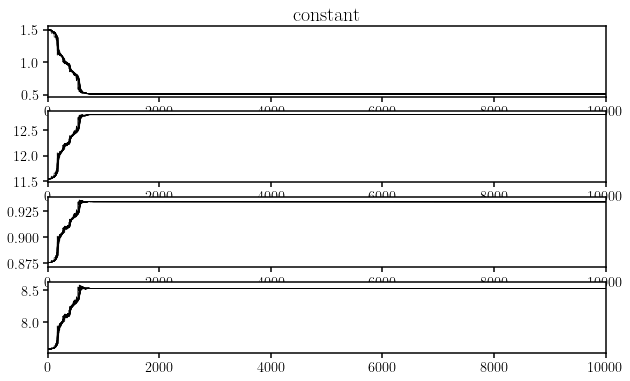

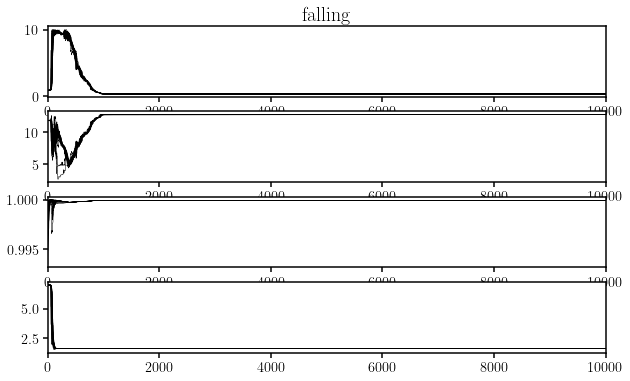

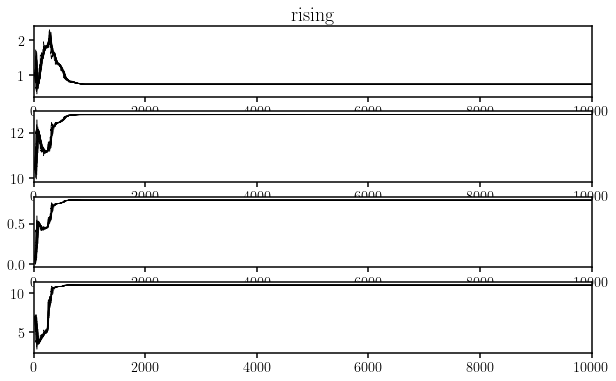

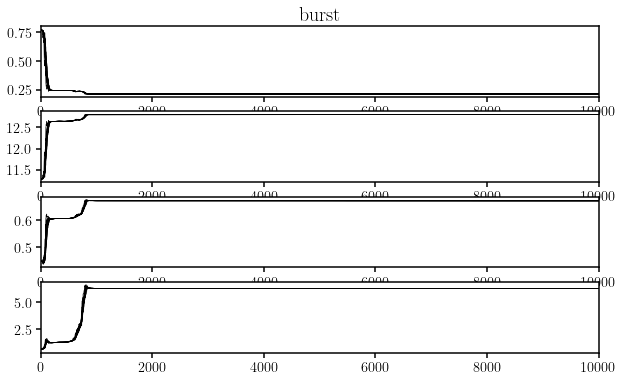

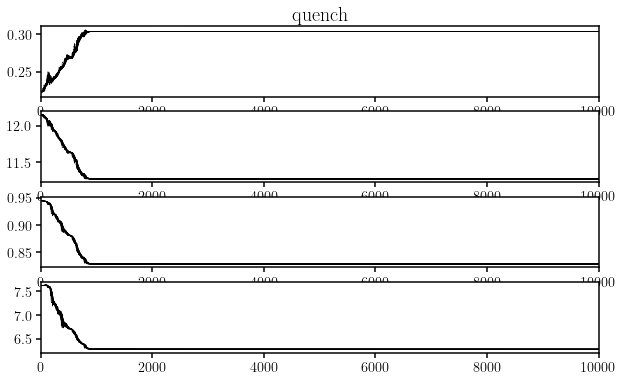

In [17]:
fluxes_bestfit, sfhs_bestfit, sfhs_chain = [], [], [] 
for chain, lbl in zip(chains, lbls): 
    fig = plt.figure(figsize=(10, 6))
    for ii in range(4): 
        sub = fig.add_subplot(4, 1, ii+1)
        for j in range(nwalkers): 
            sub.plot(chain[:,j,ii], c='k', lw=0.5)
        sub.set_xlim(0,10000)
        if ii == 0: sub.set_title(lbl, fontsize=20)
    
    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    flat_chain = chain.reshape(s)
    theta_median = np.median(flat_chain[40000:,:], axis=0)
    # calculate bestfit SED
    _, flux_bestfit = sed_tau(theta_median)
    print(theta_median)
    # calculate bestfit SFH
    sfh_bestfit = SFH(theta_median)
    
    sfh_chain = [SFH(theta_i) for theta_i in flat_chain[np.random.choice(range(4000, flat_chain.shape[0]), 1000, replace=False)]]
    
    fluxes_bestfit.append(flux_bestfit)
    sfhs_bestfit.append(sfh_bestfit)
    sfhs_chain.append(sfh_chain)

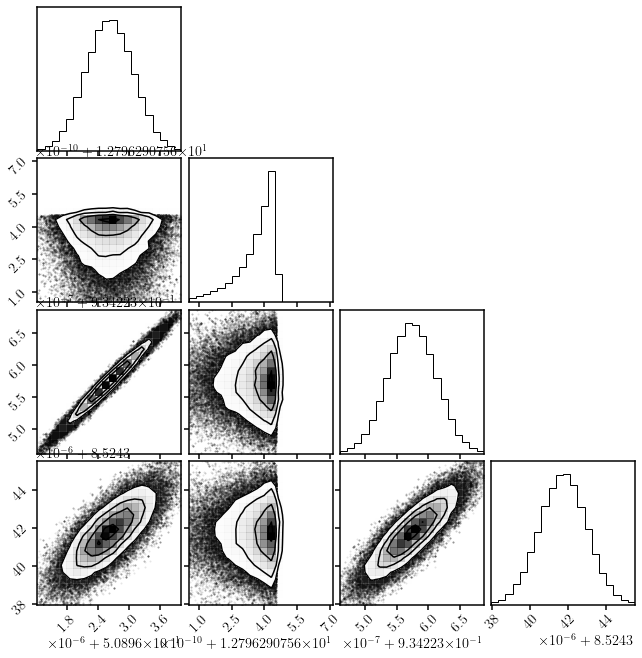

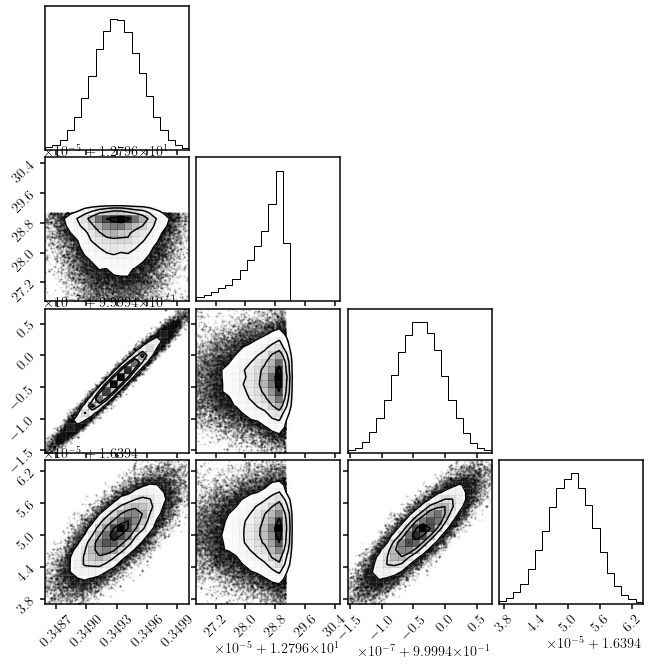

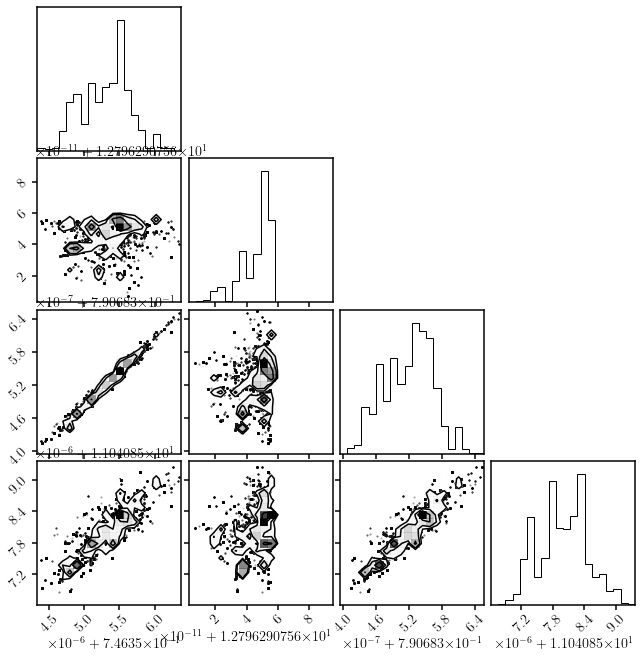

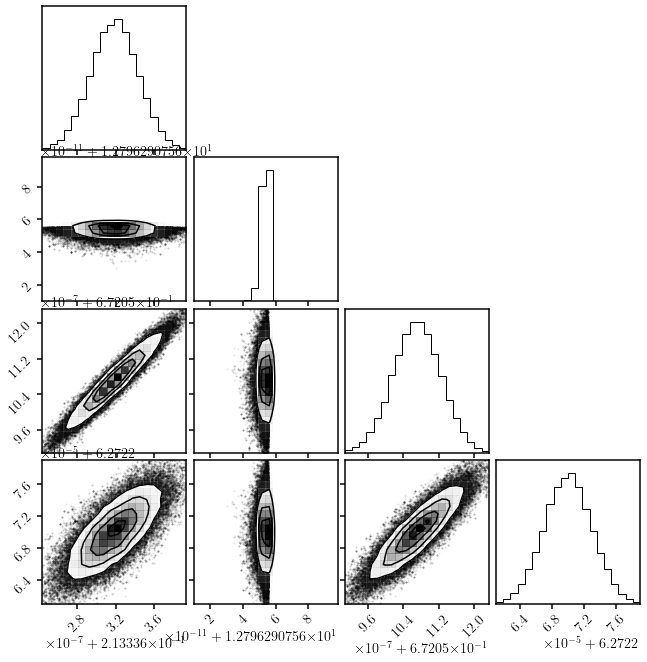

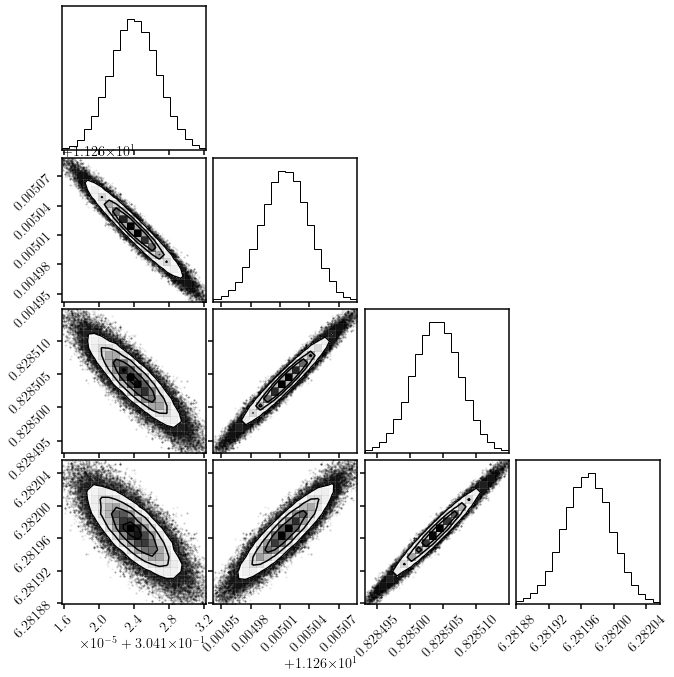

In [20]:
for chain, lbl in zip(chains, lbls): 
    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    flat_chain = chain.reshape(s)
    
    theta_median = np.median(flat_chain[40000:,:], axis=0)
    std_median = np.std(flat_chain[40000:,:], axis=0)
    fig = DFM.corner(flat_chain[40000:,:], range=[(l, h) for l, h in zip(theta_median - 3*std_median, theta_median + 3*std_median)])

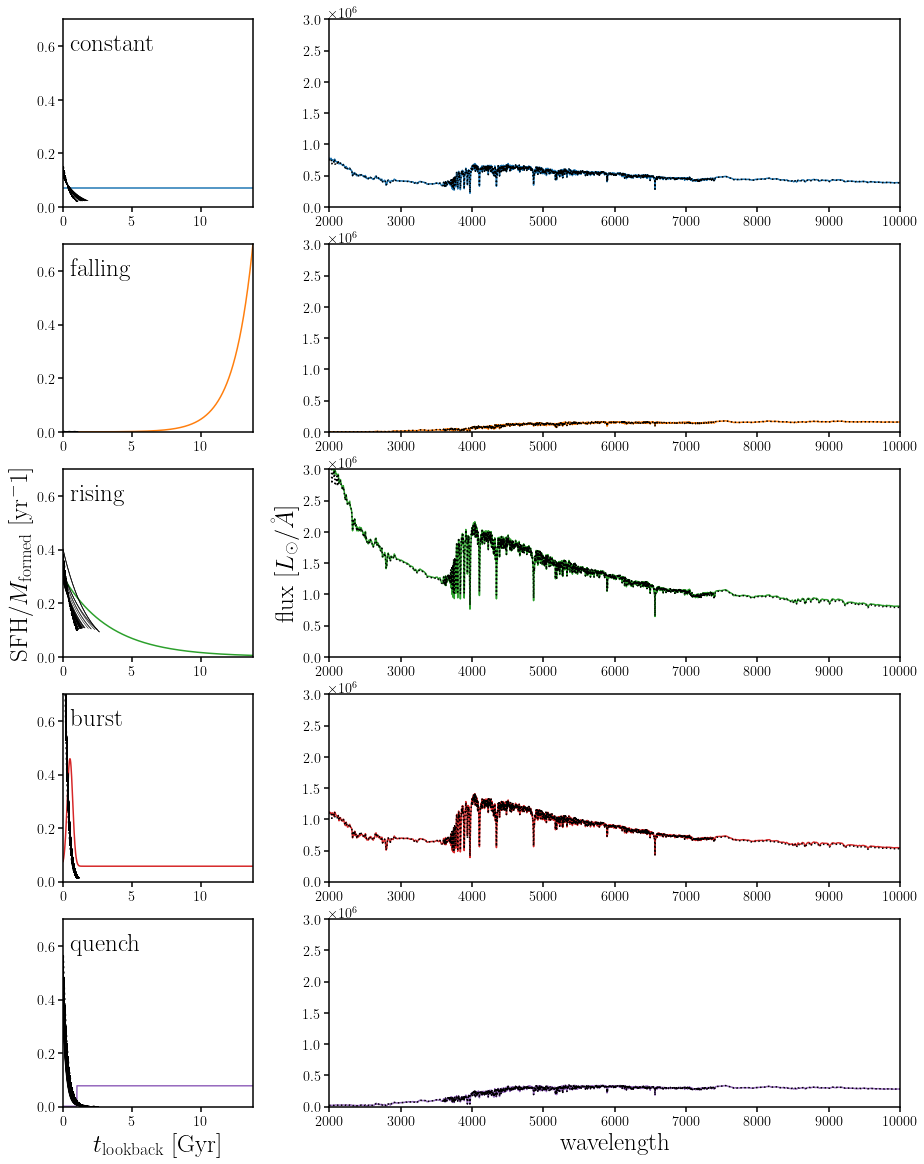

In [21]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, sfh_bf, flux_bf, lbl in zip(range(5), sfhs, seds, sfhs_bestfit, fluxes_bestfit, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    sub.plot(sfh_bf[0], sfh_bf[1], c='k', ls=':', lw=2)
    for ii in range(1000): 
        sub.plot(sfhs_chain[i][ii][0], sfhs_chain[i][ii][1], c='k', ls='-', lw=0.5)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.plot(wave, flux_bf, c='k', ls=':')
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)

In [25]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import corrprior as Corrprior

m_tau = Models.Tau(burst=True, emulator=False)

prior = Infer.load_priors([
    Infer.UniformPrior(10., 10., label='sed'), 
    Infer.UniformPrior(0.1, 10., label='sed'), # tau_SFH
    Infer.UniformPrior(0., 0., label='sed'), # const sf
    Infer.UniformPrior(0., tage-1.0000001, label='sed'), # sf_start
    Infer.UniformPrior(0., 1., label='sed'), # fburst
    Infer.UniformPrior(0., tage, label='sed'), # tburst 
    Infer.UniformPrior(0.0190, 0.0190, label='sed'),# metallicity
    Infer.UniformPrior(0.3, 0.3, label='sed')      # uniform priors on dust2
])

CP_kde = Corrprior.CorrectPrior(
    m_tau, 
    prior, 
    zred=0.,
    props=['logavgssfr_1gyr'], 
    Nprior=100000, 
    method='kde',
    bandwidth=0.005,
    range=[(-13., -9.)],
    debug=True
)

... calculating log avg sSFR_1Gyr
... fitting prior(derived prop)
... fitting pdf using kde


# get posterior on $\log{\rm SSFR}_{\rm 1~Gyr}$ from the MCMC chains

In [29]:
logssfr_chains = []
for chain, lbl in zip(chains, lbls): 
    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    flat_chain = chain.reshape(s)
    
    logssfr_chain = CP_kde._get_properties(np.array([
        np.repeat(10, flat_chain.shape[0]), 
        flat_chain[:,0], 
        np.repeat(0, flat_chain.shape[0]), 
        flat_chain[:,1], 
        flat_chain[:,2], 
        flat_chain[:,3], 
        np.repeat(0.0190, flat_chain.shape[0]), 
        np.repeat(0.3, flat_chain.shape[0])]).T)
    logssfr_chains.append(logssfr_chain)

# get true $\log {\rm SSFR}_{\rm 1~Gyr}$

In [35]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [50]:
avg_logssfr_true = []
for sfh in sfhs: 
    f_sfh = interp1d(tlb, sfh)
    sfr, _ = quad(f_sfh, 0., 1.)
    avg_logssfr_true.append(np.log10(sfr/1e9))

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.


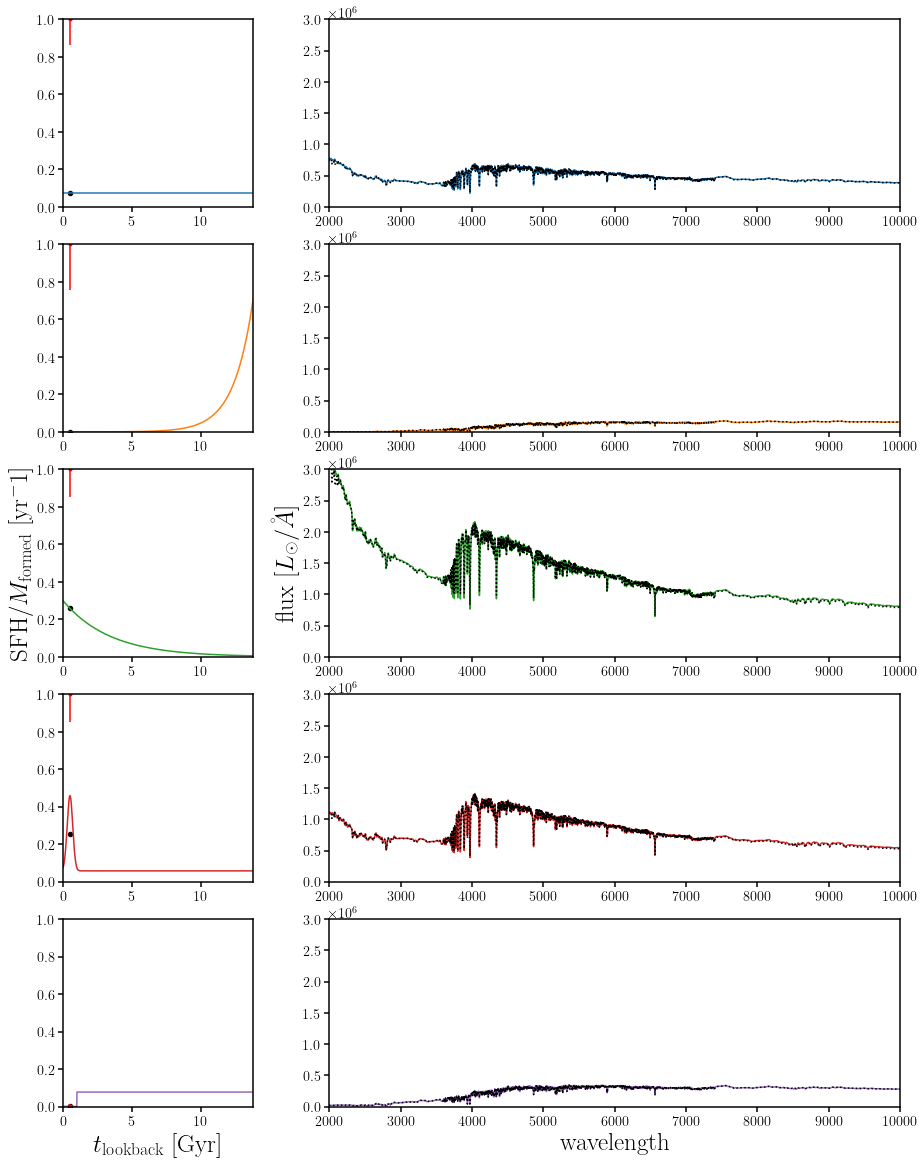

In [63]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, sfh_bf, flux_bf, lbl in zip(range(5), sfhs, seds, sfhs_bestfit, fluxes_bestfit, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    sub.scatter([0.5], 10**(avg_logssfr_true[i]+9), c='k', s=20)
    sub.errorbar([0.5], 10**(np.median(logssfr_chains[i])+9), yerr=np.std(10**(logssfr_chains[i]+9)), fmt='.r')
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 1.)
    #sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.plot(wave, flux_bf, c='k', ls=':')
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)